# Ensemble analysis

In [ ]:
#| export

from pathlib import Path

import re, shutil, numpy as np, pandas as pd
from tqdm.auto import tqdm, trange
from fastai.vision.all import *
from torch.utils.data import Dataset#, DataLoader

In [ ]:
from andi_datasets.datasets_phenom import datasets_phenom
datasets_phenom().avail_models_name

['single_state',
 'multi_state',
 'immobile_traps',
 'dimerization',
 'confinement']

In [ ]:
# load segments
# from experiment FOVs' txt files
#| export

def read_segments(data_path, track: str="2", exp: str='0'):
    """Extract segments info from the fov files in the given path."""
    stats = {"ks": [], "alphas": [], "states": [], "cps": [], "res": [],}
    # for exp_path in tqdm((data_path/f"track_{track}").iterdir(),):# total=num_FOVs):
    exp_path = data_path/f"track_{track}/exp_{exp}"
    # if not exp_path.is_dir():    continue

    traj_label_files = sorted([f for f in exp_path.iterdir() if re.search(r"fov_\d*.txt", f.name)])
    
    for file in traj_label_files:
        with open(file, "r") as f:
            traj_info = f.readlines()

        fov_ks, fov_alphas, fov_states, fov_cps, fov_res_time = [], [], [], [], []
        for info in traj_info:
            ks, alphas, states, cps = _parse_trajectory_info(info)
            fov_ks.append(ks)
            fov_alphas.append(alphas)
            fov_states.append(states)
            fov_cps.append(cps)
            if len(cps)>1:
                fov_res_time.append(cps[0:1]+[cp-cp_ for cp, cp_ in zip(cps[1:],cps[:-1])])
            elif len(cps)==1:
                fov_res_time.append(cps)
            else:
                raise Error
        stats["ks"].append(fov_ks)
        stats["alphas"].append(fov_alphas)
        stats["states"].append(fov_states)
        stats["cps"].append(fov_cps)
        stats["res"].append(fov_res_time)
        
    return stats

def _parse_trajectory_info(info):
    """Extract the trajectory information from the labels. 
    The file format is:
    traj_idx,K_0,alpha_0,state_0,cp_0,...,state_n,traj_len"""
    ks, alphas, states, cps = [], [], [], []
    split_info = re.findall(r"\d*,(.*)\n$", info)[0].split(",")
    ks.extend(    [float(f)  for f in split_info[::4]])
    alphas.extend([float(f)  for f in split_info[1::4]])
    states.extend([int(i[0]) for i in split_info[2::4]])
    cps.extend(   [int(i)    for i in split_info[3::4]])
    return ks, alphas, states, cps

In [ ]:
path_submit = Path('../../data/submit/20240713/')  # 20240710/')  # 20240628/')
path_results = path_submit/'res/'

In [ ]:
!ls {path_results/'track_2/exp_0'}

fov_0.txt   fov_14.txt	fov_19.txt  fov_23.txt	fov_28.txt  fov_5.txt
fov_10.txt  fov_15.txt	fov_1.txt   fov_24.txt	fov_29.txt  fov_6.txt
fov_11.txt  fov_16.txt	fov_20.txt  fov_25.txt	fov_2.txt   fov_7.txt
fov_12.txt  fov_17.txt	fov_21.txt  fov_26.txt	fov_3.txt   fov_8.txt
fov_13.txt  fov_18.txt	fov_22.txt  fov_27.txt	fov_4.txt   fov_9.txt


In [ ]:
df = pd.read_csv(path_results/'track_2/exp_0/fov_0.txt', sep=" ", header=None); df

,0
0,"0,2.6169715e-09,1.1719866,2,200"
1,"1,3.2838274e-10,0.7607969,2,24,5.9254886e-11,0.76059145,2,84,7.8396495e-10,0.7622696,2,94,4.4961087e-11,0.76091087,2,178,6.690264e-10,0.7625704,2,200"
2,"2,0.067988314,1.1012747,2,171,0.9401587,1.1019096,2,191,0.031808544,1.1021203,2,200"
3,"3,8.7207276e-11,0.9644041,2,200"
4,"4,0.24677333,1.0392189,2,200"
5,"5,5.0058097e-11,1.0167137,2,110,3.6564994e-11,0.9817982,2,174,5.8163602e-11,0.97794396,2,192,3.2963986e-11,0.98614675,2,200"
6,"6,0.045088418,0.88427323,2,200"
7,"7,1.081834e-10,0.86114424,2,164,7.257538e-10,0.85694414,2,180,2.3560204e-10,0.85510844,2,200"
8,"8,3.6930378e-10,1.0162939,2,103,9.04621e-11,1.0141524,2,150"
9,"9,0.027307326,0.97872114,2,200"


In [ ]:
num_states_exp = [2,2,5,4,5,2,2,6,5,3, 4, 6] #[2,2, 4 ,4,4,3*,2,2,2,3*, 5*, 4*] #[2,2,2,2,4,2,2,3,2,3,4,3,3]

In [ ]:
def flattten_list_to_array(l): return np.concatenate([subitem for item in l for subitem in item])

In [ ]:
# dry run, not saved
for exp, n_states in enumerate(num_states_exp):
    seg = read_segments(path_results, exp=str(exp))
    seg_flat = list(map(flattten_list_to_array, [seg[label] for label in ["alphas", "ks", "states", "cps", "res"]]))
    seg_flat_alphas, seg_flat_ks, seg_flat_states, seg_flat_cps, seg_flat_res = seg_flat 

    scaler = StandardScaler()
    x = np.stack((np.log10(seg_flat_ks), seg_flat_alphas, seg_flat_states), axis=-1)
    x = scaler.fit_transform(x)
    
    # sse = []
    # n_clusters = np.arange(1, 8)
    # for n in tqdm(n_clusters):
    #     kmeans = KMeans(init="k-means++", n_clusters=n, n_init=10, max_iter=300, random_state=42)
    #     kmeans.fit(x)
    #     sse.append(kmeans.inertia_)
    kmeans = KMeans(init="k-means++", n_clusters=n_states,#kl.elbow,
                    n_init=10, max_iter=300, random_state=42)
    kmeans.fit(x)
    seg_labels = kmeans.predict(x)
    data = np.zeros((5,n_states))
    assert n_states==kmeans.n_clusters
    print(f'Exp {exp}')
    for i in range(kmeans.n_clusters):
        if sum(seg_labels==i)/len(seg_labels)<.03: continue
        data[0,i] = np.mean(seg_flat_alphas[seg_labels==i]) # weight with residence_time??
        data[1,i] = np.var (seg_flat_alphas[seg_labels==i])
        data[2,i] = np.mean(seg_flat_ks    [seg_labels==i])
        data[3,i] = np.var (seg_flat_ks    [seg_labels==i])
        data[4,i] = np.sum(seg_flat_res[seg_labels==i])/np.sum(seg_flat_res)
        # print(f'mu D = {np.mean(10**seg_flat_ks[seg_labels==i]):.3g}')
        print(f'mu  a = {data[0,i]:.3g}')
        print(f'var a = {data[1,i]:.3g}')
        print(f'mu  D = {data[2,i]:.3g}')
        print(f'var D = {data[3,i]:.3g}')
        print(f'res T = {data[4,i]:.1%}')
        print(f'label = {sum(seg_labels==i)/len(seg_labels):.1%}')
        print()
    print('-'*8)

Exp 0
mu  a = 1.02
var a = 0.00722
mu  D = 0.948
var D = 26.9
res T = 48.4%
label = 38.7%

mu  a = 0.986
var a = 0.0109
mu  D = 3.39e-07
var D = 4.8e-11
res T = 51.6%
label = 61.3%

--------
Exp 1
mu  a = 1
var a = 0.00889
mu  D = 1.57
var D = 91.9
res T = 45.7%
label = 38.9%

mu  a = 1
var a = 0.0105
mu  D = 4.01e-08
var D = 4.33e-14
res T = 54.3%
label = 61.1%

--------
Exp 2
mu  a = 1.07
var a = 0.0186
mu  D = 2.41e-06
var D = 8.36e-11
res T = 14.3%
label = 23.5%

mu  a = 0.315
var a = 0.0219
mu  D = 5.47e-08
var D = 1.93e-13
res T = 6.8%
label = 8.2%

mu  a = 1.07
var a = 0.0174
mu  D = 19.6
var D = 3.91e+03
res T = 70.4%
label = 57.5%

mu  a = 0.367
var a = 0.035
mu  D = 20.6
var D = 1.07e+04
res T = 6.0%
label = 8.3%

--------
Exp 3
mu  a = 0.578
var a = 0.142
mu  D = 1.02e-07
var D = 4.24e-13
res T = 23.7%
label = 29.9%

mu  a = 1.07
var a = 0.0201
mu  D = 25.8
var D = 1.32e+04
res T = 37.8%
label = 36.8%

mu  a = 0.29
var a = 0.00753
mu  D = 11
var D = 7.63e+03
res T = 14.1%
la

In [ ]:
for track in [2]:    
    # Create the folder of the track if it does not exists
    path_track = path_results / f'track_{track}/'
    if not os.path.exists(path_track):    os.makedirs(path_track)

    for exp, n_states in enumerate(num_states_exp):
        # create data states from segment predictions
        print(f'Exp {exp}')
        seg = read_segments(path_results, exp=str(exp))
        seg_flat = list(map(flattten_list_to_array, [seg[label] for label in ["alphas", "ks", "states", "cps", "res"]]))
        seg_flat_alphas, seg_flat_ks, seg_flat_states, seg_flat_cps, seg_flat_res = seg_flat 
    
        scaler = StandardScaler()
        x = np.stack((np.log10(seg_flat_ks), seg_flat_alphas, seg_flat_states), axis=-1)
        x = scaler.fit_transform(x)
        
        # sse = []
        # n_clusters = np.arange(1, 8)
        # for n in tqdm(n_clusters):
        #     kmeans = KMeans(init="k-means++", n_clusters=n, n_init=10, max_iter=300, random_state=42)
        #     kmeans.fit(x)
        #     sse.append(kmeans.inertia_)
        kmeans = KMeans(init="k-means++", n_clusters=n_states,#kl.elbow,
                        n_init=10, max_iter=300, random_state=42)
        kmeans.fit(x)
        seg_labels = kmeans.predict(x)
        data = np.zeros((5,n_states))
        assert n_states==kmeans.n_clusters
        n_states_ = 0
        for i in range(kmeans.n_clusters):
            if sum(seg_labels==i)/len(seg_labels)<.03: continue
            n_states_+=1
            data[0,i] = np.mean(seg_flat_alphas[seg_labels==i]) # weight with residence_time??
            data[1,i] = np.var (seg_flat_alphas[seg_labels==i])
            data[2,i] = np.mean(seg_flat_ks    [seg_labels==i])
            data[3,i] = np.var (seg_flat_ks    [seg_labels==i])
            data[4,i] = np.sum(seg_flat_res[seg_labels==i])/np.sum(seg_flat_res)
            # print(f'mu D = {np.mean(10**seg_flat_ks[seg_labels==i]):.3g}')
            print(f'mu  a = {data[0,i]:.3g}')
            print(f'var a = {data[1,i]:.3g}')
            print(f'mu  D = {data[2,i]:.3g}')
            print(f'var D = {data[3,i]:.3g}')
            print(f'res T = {data[4,i]:.1%}')
            print(f'label = {sum(seg_labels==i)/len(seg_labels):.1%}')
            print()
        print('-'*8)
        # save the data in a file for submission
        # Create the folder of the experiment if it does not exits
        path_exp = path_track/f'exp_{exp}/'
        if not os.path.exists(path_exp):  os.makedirs(path_exp)
        file_name = path_exp / 'ensemble_labels.txt'
        with open(file_name, 'a') as f:
            # Save the model (random) and the number of states
            model_name = np.random.choice(datasets_phenom().avail_models_name, size = 1)[0]
            f.write(f'model: {model_name}; num_state: {n_states_} \n')
            # Save the data in the corresponding ensemble file
            np.savetxt(f, data, delimiter = ';')
            print(f'Saved data at {f}')

Exp 0
mu  a = 1.02
var a = 0.00722
mu  D = 0.948
var D = 26.9
res T = 48.4%
label = 38.7%

mu  a = 0.986
var a = 0.0109
mu  D = 3.39e-07
var D = 4.8e-11
res T = 51.6%
label = 61.3%

--------
Saved data at <_io.TextIOWrapper name='../../data/submit/20240713/res/track_2/exp_0/ensemble_labels.txt' mode='a' encoding='UTF-8'>
Exp 1
mu  a = 1
var a = 0.00889
mu  D = 1.57
var D = 91.9
res T = 45.7%
label = 38.9%

mu  a = 1
var a = 0.0105
mu  D = 4.01e-08
var D = 4.33e-14
res T = 54.3%
label = 61.1%

--------
Saved data at <_io.TextIOWrapper name='../../data/submit/20240713/res/track_2/exp_1/ensemble_labels.txt' mode='a' encoding='UTF-8'>
Exp 2
mu  a = 1.07
var a = 0.0186
mu  D = 2.41e-06
var D = 8.36e-11
res T = 14.3%
label = 23.5%

mu  a = 0.315
var a = 0.0219
mu  D = 5.47e-08
var D = 1.93e-13
res T = 6.8%
label = 8.2%

mu  a = 1.07
var a = 0.0174
mu  D = 19.6
var D = 3.91e+03
res T = 70.4%
label = 57.5%

mu  a = 0.367
var a = 0.035
mu  D = 20.6
var D = 1.07e+04
res T = 6.0%
label = 8.3%

--

## Examples

In [ ]:
exp = 11

In [ ]:
seg = read_segments(path_results, exp=str(exp))

In [ ]:
def flattten_list_to_array(l): return np.concatenate([subitem for item in l for subitem in item])

In [ ]:
seg_flat = list(map(flattten_list_to_array, [seg[label] for label in ["alphas", "ks", "states", "cps", "res"]]))
seg_flat_alphas, seg_flat_ks, seg_flat_states, seg_flat_cps, seg_flat_res = seg_flat 

In [ ]:
# from functools import partial
# plt.hist= partial(plt.hist, histtype='step')

In [ ]:
#plt.hist(seg_flat_alphas,100, log=1);

In [ ]:
# plt.hist(seg_flat_ks,bins=np.geomspace(1e-4,10,200));plt.xscale('log');plt.ylim(0,100);

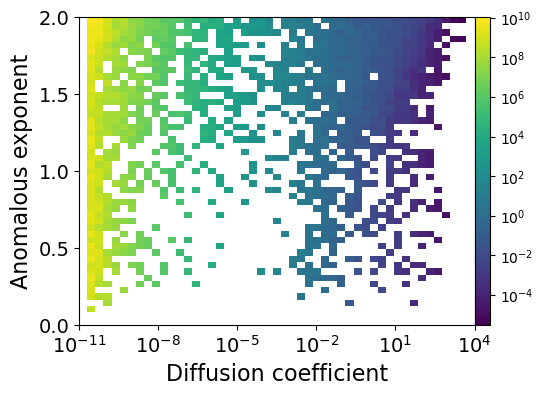

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist2d(seg_flat_ks, seg_flat_alphas, 
           bins=[#np.geomspace(1e-7,1e3,50),
                 np.geomspace(1e-11,1e4,50),
                 np.linspace(0,2,50)], density=True,
           # cmap=cmap
           norm=matplotlib.colors.LogNorm(),
          );

plt.colorbar(pad=0);
plt.xlabel('Diffusion coefficient', fontsize=16); plt.xscale('log');
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

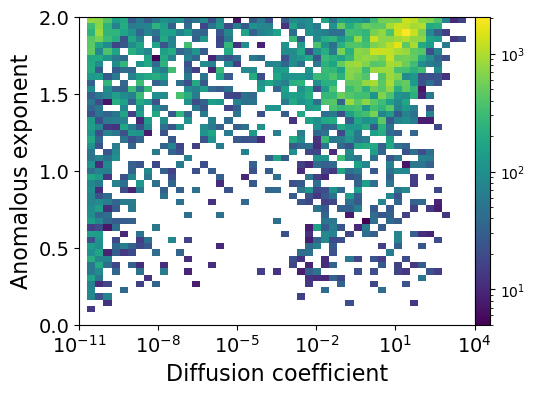

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist2d(seg_flat_ks, seg_flat_alphas, 
           bins=[#np.geomspace(1e-7,1e3,50),
                 np.geomspace(1e-11, 1e4,50),
                 np.linspace(0,2,50)],
           # cmap=cmap
           weights = seg_flat_res,
           norm=matplotlib.colors.LogNorm(),
          );
plt.colorbar(pad=0);

plt.xlabel('Diffusion coefficient', fontsize=16); plt.xscale('log');
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

# Clustering segments

In [ ]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.colors as clr

In [ ]:
scaler = StandardScaler()
x = np.stack((np.log10(seg_flat_ks), seg_flat_alphas, seg_flat_states), axis=-1)
x = scaler.fit_transform(x)

sse = []
n_clusters = np.arange(1, 8)
for n in tqdm(n_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=n, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

  0%|          | 0/7 [00:00<?, ?it/s]

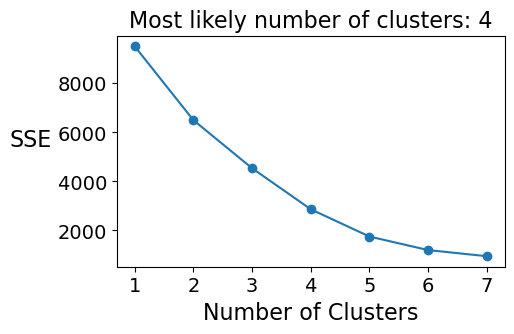

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(n_clusters, sse, 'o-')
plt.xticks(n_clusters)
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("SSE", rotation=0,ha='right', fontsize=16)
plt.tick_params(labelsize=14)
kl = KneeLocator(n_clusters, sse, curve="convex", direction="decreasing")
plt.title(f"Most likely number of clusters: {kl.elbow}", fontsize=16);

In [ ]:
num_states_exp[exp]

6

In [ ]:
kmeans = KMeans(init="k-means++", n_clusters=num_states_exp[exp],#kl.elbow,
                n_init=10, max_iter=300, random_state=42)
kmeans.fit(x)
seg_labels = kmeans.predict(x)

In [ ]:
for i in range(kmeans.n_clusters):
    print(f'perc = {sum(seg_labels==i)/len(seg_labels):.1%}')
    print(f'perc T = {sum(seg_flat_res[seg_labels==i])/sum(seg_flat_res):.1%}')

    # print(f'mu D = {np.mean(10**seg_flat_ks[seg_labels==i]):.3g}')
    print(f'mu  D = {np.mean(seg_flat_ks    [seg_labels==i]):.3g}')
    print(f'std D = {np.std(seg_flat_ks    [seg_labels==i]):.3g}')
    print(f'mu a = {np.mean(seg_flat_alphas[seg_labels==i]):.3g}')
    print(f'std a = {np.std(seg_flat_alphas[seg_labels==i]):.3g}')
    print()

perc = 11.2%
perc T = 7.7%
mu  D = 20.1
std D = 82.3
mu a = 0.833
std a = 0.307

perc = 51.4%
perc T = 65.8%
mu  D = 43.4
std D = 199
mu a = 1.75
std a = 0.186

perc = 23.2%
perc T = 19.3%
mu  D = 1.42e-06
std D = 6.76e-06
mu a = 1.74
std a = 0.224

perc = 0.9%
perc T = 0.4%
mu  D = 10.3
std D = 44.7
mu a = 0.903
std a = 0.405

perc = 10.9%
perc T = 5.3%
mu  D = 5.93e-08
std D = 3.19e-07
mu a = 0.726
std a = 0.297

perc = 2.4%
perc T = 1.5%
mu  D = 55.9
std D = 116
mu a = 1.83
std a = 0.333



In [ ]:
color_order = ['blue', 'orange', 'yellow', 'purple', 'green']; colors = [f'C{i}' for i in range(5)]

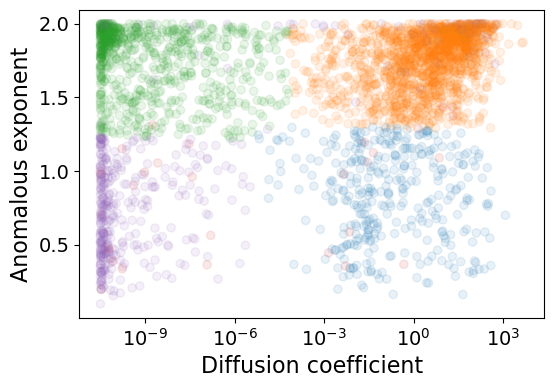

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(seg_flat_ks, seg_flat_alphas, c=seg_labels, alpha=0.1, 
            cmap=clr.ListedColormap(colors), norm=clr.BoundaryNorm(np.arange(5), 4))

plt.xlabel('Diffusion coefficient', fontsize=16); plt.xscale('log');
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

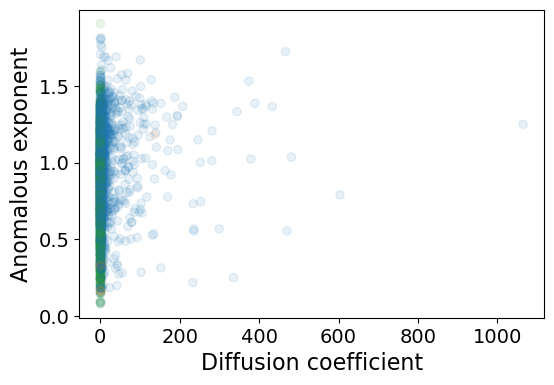

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(#np.log10(seg_flat_ks),
            seg_flat_ks,
            seg_flat_alphas, c=seg_labels, alpha=0.1, 
            cmap=clr.ListedColormap(colors), norm=clr.BoundaryNorm(np.arange(5), 4))

plt.xlabel('Diffusion coefficient', fontsize=16);
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)